In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import os

In [3]:
current = np.arange(0,7.04,0.02)
field = 1.61893 + 26.1952 * current # length of field is number of files

directory = os.path.join("HRRYIG180","HRRYIG180")

In [4]:
def read_s_params(directory, log=True):
    

    files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    s_parameters = dict()

    freqs = pd.read_csv(os.path.join(directory, files[0]), header=0, index_col=0).index.to_numpy()

    for file in files:
        data = pd.read_csv(os.path.join(directory, file), header=0, index_col=0)
        for key in data.keys():
            if key not in s_parameters:
                s_parameters[key] = np.empty((len(files), len(data)))
            if log:
                out_data = 20* np.log10(np.abs(data[key].to_numpy()))
            else:
                out_data = data[key].to_numpy()
            s_parameters[key][files.index(file), :] = out_data
    

    return s_parameters, freqs

In [9]:
def s_param_plot(directory=directory, norm=True, log=True, grad=True, smooth='gaussian', cmap="inferno_r",sigma=5):

    # cmap = "inferno" if not log else "inferno_r"

    s_parameters, freqs = read_s_params(directory, log=log)

    # fig, ax = plt.subplots(1,1); axs = np.array([ax])
    fig, axs = plt.subplots(2,2, figsize=(10, 10),sharey=True)
    keys = ['S11', 'S21', 'S12', 'S22']
    # keys = ['S21']
    for i, ax in enumerate(axs.flat):
        plot_data = np.abs(s_parameters[f'{keys[i]}_Real']+1j*s_parameters[f'{keys[i]}_Imaginary'])
        if grad:
            plot_data = np.gradient(plot_data, axis=1) # need to pick CORRECT AXIS
        if norm:
            plot_data -= plot_data[0,:]  # Subtract the first row for normalization
        if smooth == 'gaussian':
            plot_data = gaussian_filter1d(plot_data, sigma=sigma, axis=1)
        if norm:
            maximum = np.max([np.abs(plot_data.min()),np.abs(plot_data.max())])
            im = ax.pcolormesh(field,freqs*1e-9,plot_data.T,cmap=cmap,vmin=-maximum, vmax=maximum)
        else:
            im = ax.pcolormesh(field,freqs*1e-9,plot_data.T,cmap=cmap)
        if i % 2 == 0:
            ax.set_ylabel("Freq (GHz)")
        ax.set_xlabel("Field (mT)")
        ax.set_title(f"{keys[i]} Magnitude")
        # ax.set_ylim(2.5,7.5)
    if smooth==None:
        smooth = "un"
    fig.suptitle(directory+norm*" Normed"+grad*" grad", fontsize=16)
    plt.tight_layout()
    # plt.colorbar(im,label="$S_{21}$"+" (dB)"*log)
    filename = directory + "_normalised"*norm + "_gradient" * grad + "_dB_" * log + smooth+"_smooth" + ".png"
    # plt.savefig(filename,transparent=True)
    plt.show()

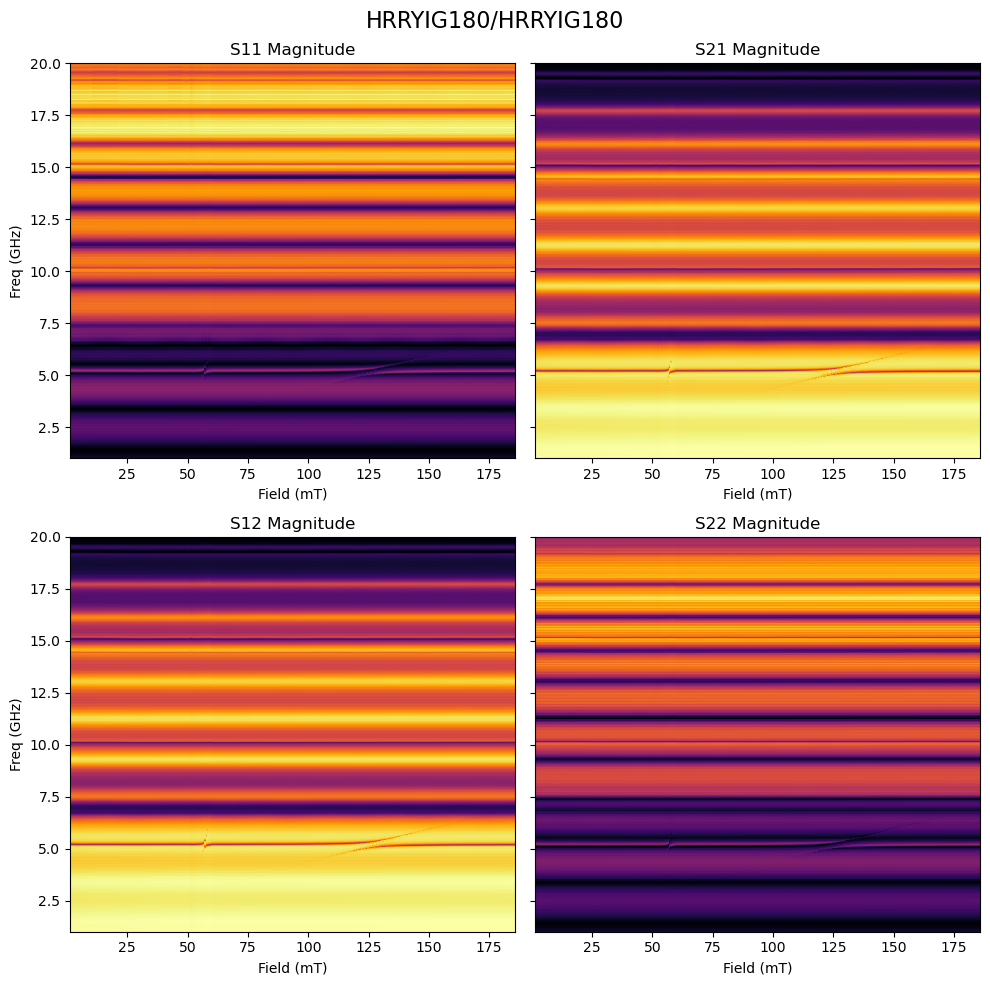

In [10]:
maps = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                      'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic',
                      'berlin', 'managua', 'vanimo']

# for map in maps:
#     print(map)
#     s_param_plot(cmap=map, sigma=5)#, norm=False) # default values

s_param_plot(directory=directory,cmap="inferno",sigma=5,grad=0,norm=0,smooth=None,log=0) # default values

Processing directory: HRRPY180/HRRPY180


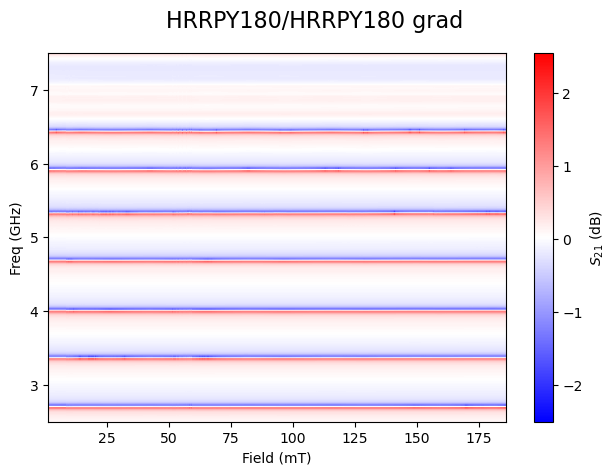

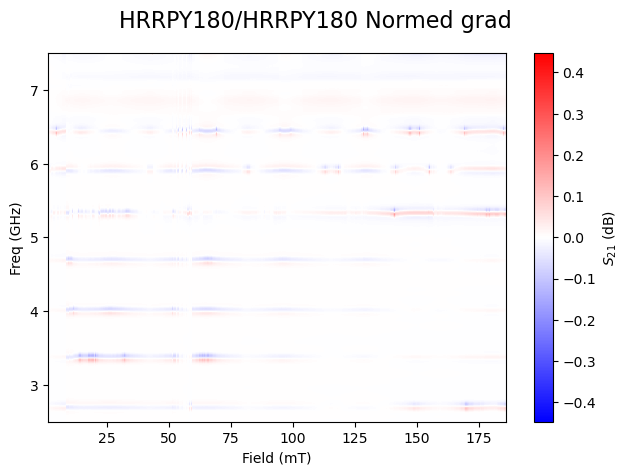

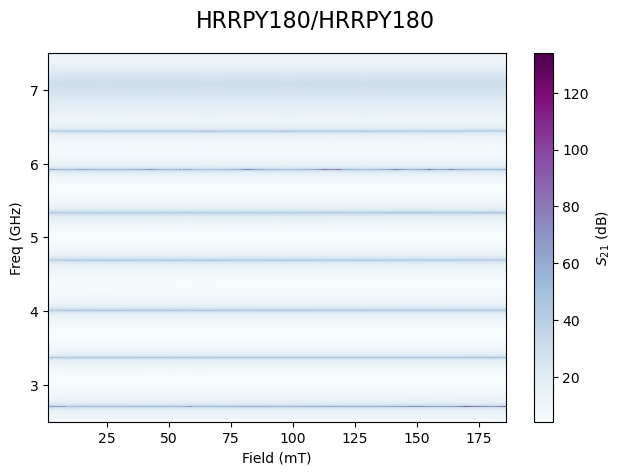

Processing directory: HRRPY180/HRRYIG_BJ_PY


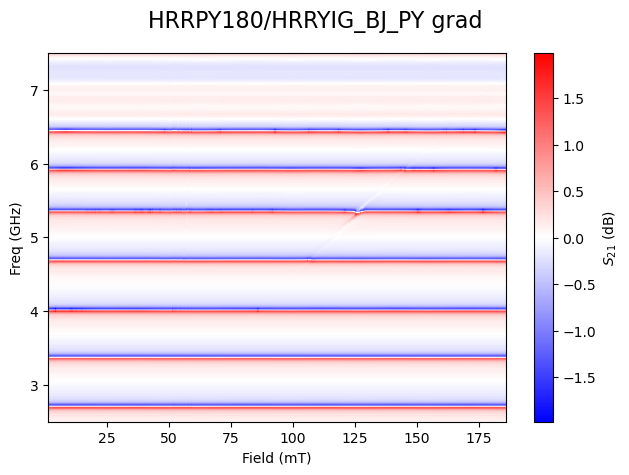

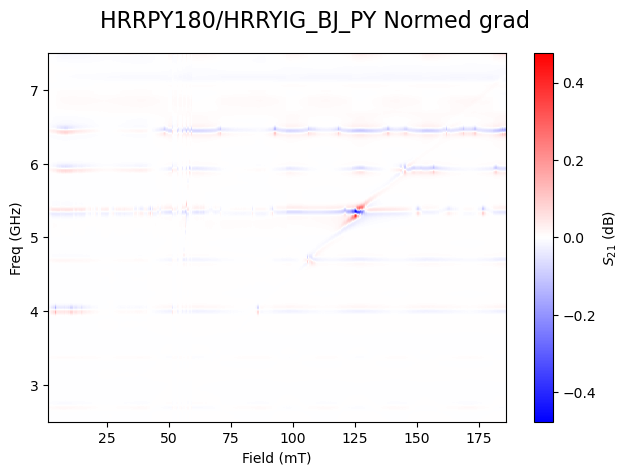

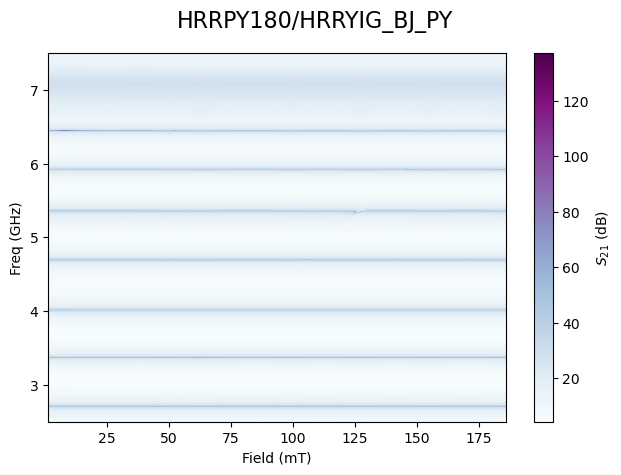

Processing directory: HRRYIG180/HRRYIG180


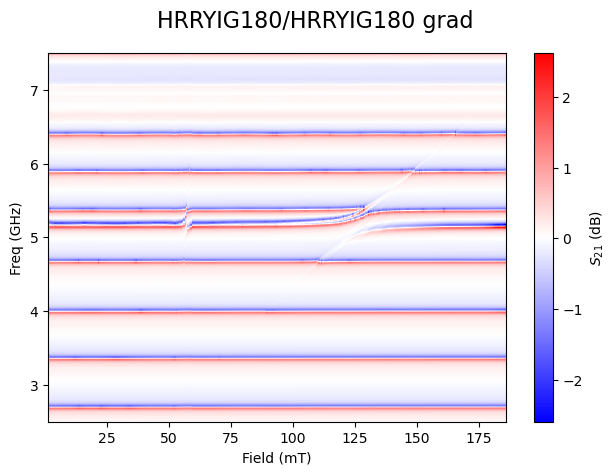

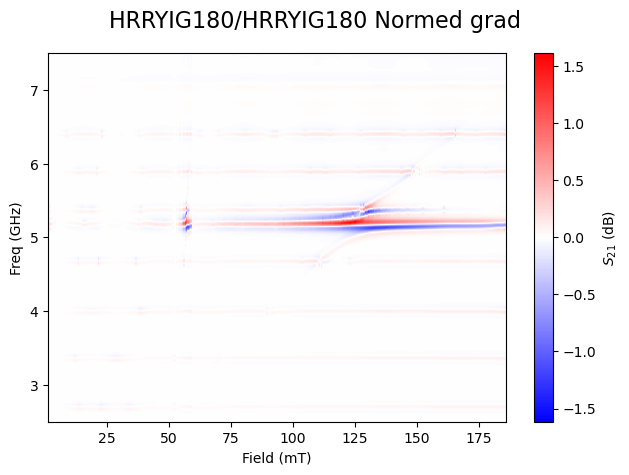

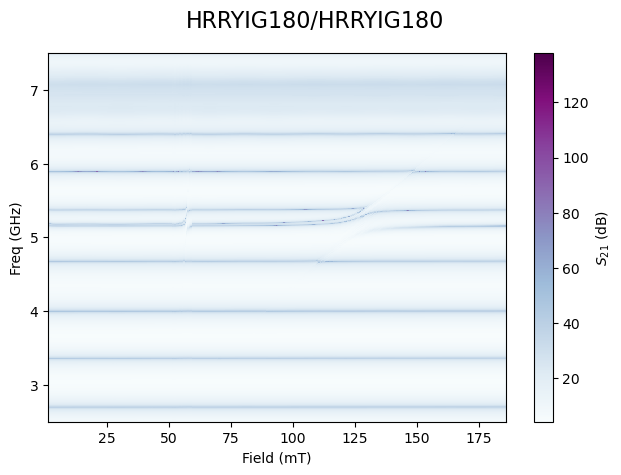

Processing directory: HRRYIG_PY/HRRYIG_PY


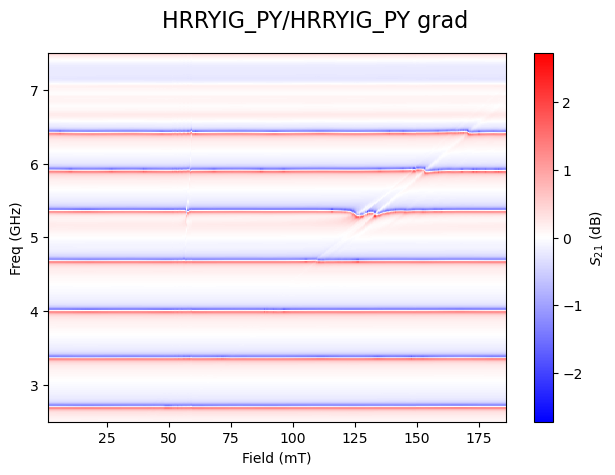

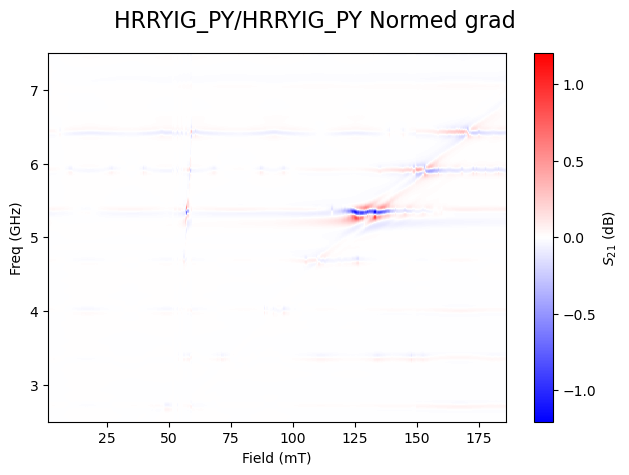

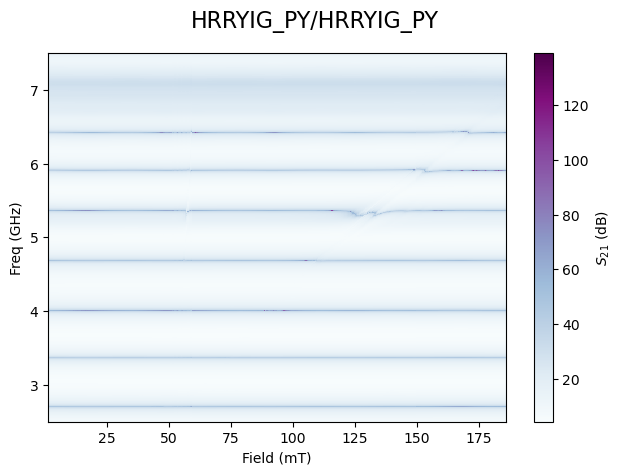

Processing directory: HRRYIG_PY/HRRYIG_SPS_PY


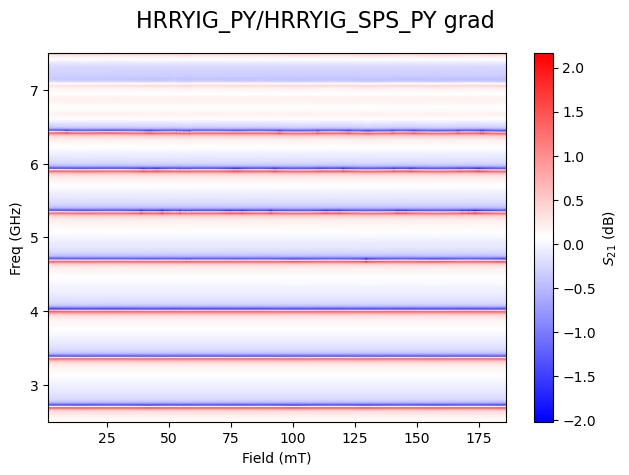

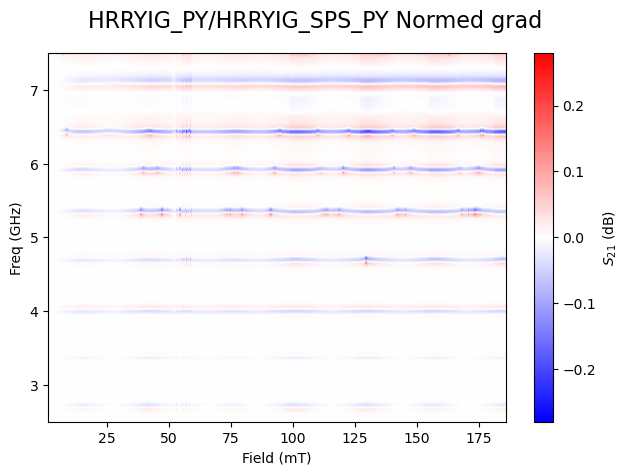

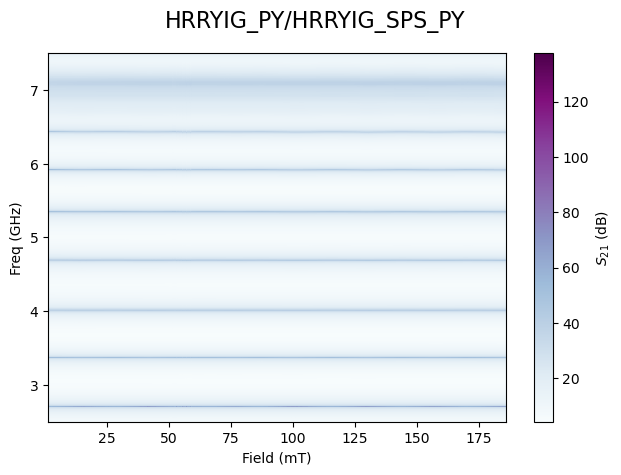

In [11]:
dirs = os.listdir(".")
for d in dirs:
    if os.path.isdir(d) and d.startswith("HRR"):
        # Check if there are any directories inside d
        subdirs = [name for name in os.listdir(d) if os.path.isdir(os.path.join(d, name))]
        for sd in subdirs:
            directory = os.path.join(d, sd)
            print(f"Processing directory: {directory}")
            # s_param_plot(directory, norm=True)
            s_param_plot(directory,norm=False,cmap="bwr",sigma=5) 
            s_param_plot(directory,cmap="bwr",sigma=10) 
            s_param_plot(directory,norm=False,cmap="BuPu",grad=False,smooth=None) 

In [ ]:
data = read_s_params(directory)[0]
# data['S21_Real']+1j*data['S21_Imaginary']
np.savez("s_params_BJ.npz", **data, allow_pickle=False)

In [ ]:
s21 = data['S21_Real'] + 1j * data['S21_Imaginary']

pd.DataFrame(s21, index=field).to_csv("s21.csv")

In [34]:
s21=read_s_params(directory)

In [35]:
s21 = pd.read_csv(os.path.join(directory, "0001.csv"), header=0, index_col=0)

s21

,S11_Real,S11_Imaginary,S21_Real,S21_Imaginary,S12_Real,S12_Imaginary,S22_Real,S22_Imaginary
Frequency (Hz),,,,,,,,
1.000000e+09,-0.087225,0.059264,-0.671546,-0.728944,-0.667954,-0.726358,-0.084519,0.061975
1.002969e+09,-0.086200,0.059211,-0.676684,-0.724370,-0.673075,-0.721824,-0.083352,0.062022
1.005938e+09,-0.085151,0.059162,-0.681793,-0.719770,-0.678121,-0.717194,-0.082112,0.062150
1.008906e+09,-0.084095,0.059182,-0.686845,-0.715082,-0.683138,-0.712525,-0.080803,0.062397
1.011875e+09,-0.083054,0.059306,-0.691808,-0.710336,-0.688136,-0.707788,-0.079453,0.062759
...,...,...,...,...,...,...,...,...
1.998812e+10,0.464938,0.636289,0.035041,0.041322,0.033636,0.041945,0.448952,0.086436
1.999109e+10,0.467455,0.631645,0.035138,0.041321,0.033604,0.041934,0.450446,0.079913
1.999406e+10,0.470554,0.627927,0.035022,0.041182,0.033650,0.041876,0.452159,0.074050


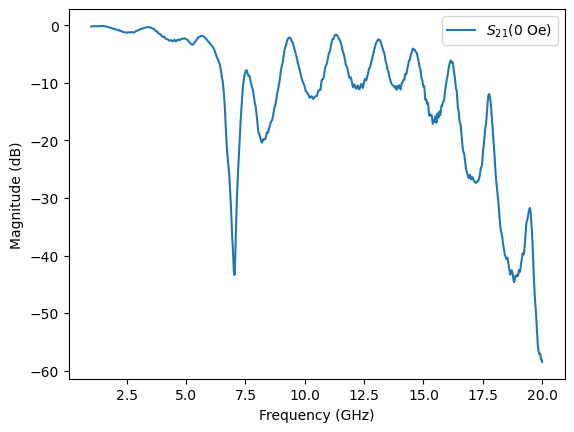

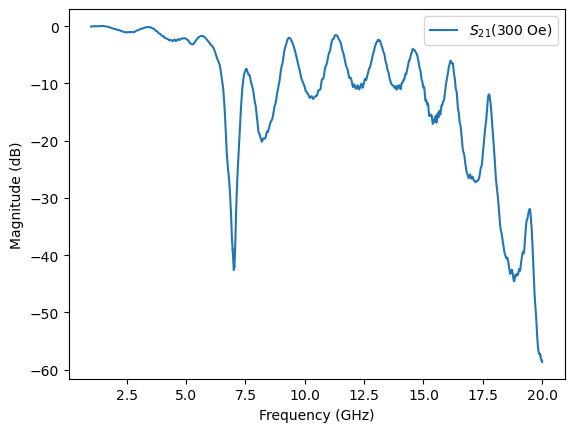

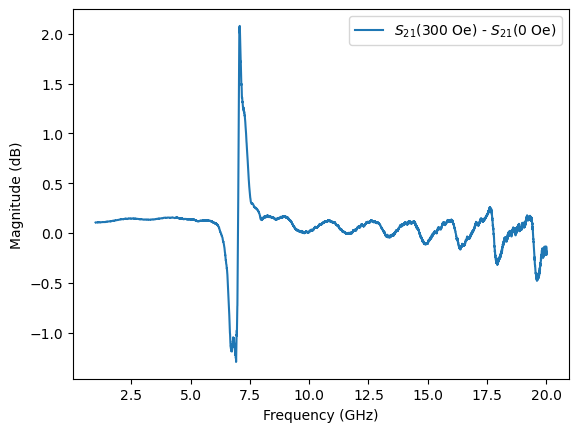

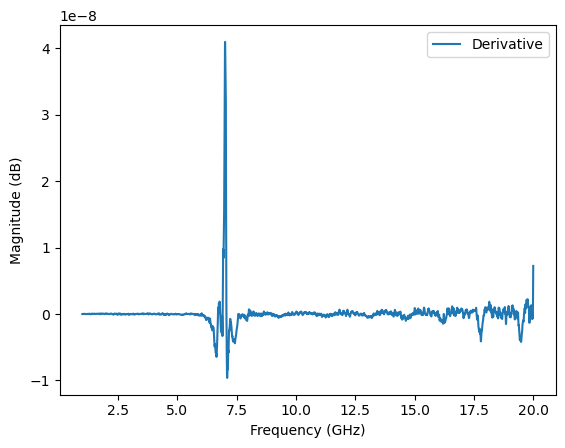

In [36]:
from scipy.ndimage import gaussian_filter1d

# plt.plot(s21.index/1e9, 20*np.log(np.abs(s21['S21_Real'] + 1j * s21['S21_Imaginary'])))
s21_ = pd.read_csv(os.path.join(directory, "0300.csv"), header=0, index_col=0)
data0field = 20*np.log(np.abs(s21['S21_Real'] + 1j * s21['S21_Imaginary']))
data_field = 20*np.log(np.abs(s21_['S21_Real'] + 1j * s21_['S21_Imaginary']))
data = data_field - data0field
derivative = np.gradient(data, s21.index)
smoothed_derivative = gaussian_filter1d(derivative, sigma=3)
smoothed_data = gaussian_filter1d(data, sigma=25)

plt.plot(s21.index/1e9, data0field, label="$S_{21}$(0 Oe)")
plt.legend()
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.show()

plt.plot(s21.index/1e9, data_field, label="$S_{21}$(300 Oe)")
plt.legend()
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.show()

plt.plot(s21.index/1e9, data, label="$S_{21}$(300 Oe) - $S_{21}$(0 Oe)")
plt.legend()
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.show()

plt.plot(s21.index/1e9, smoothed_derivative, label="Derivative")
plt.legend()
plt.ylabel("Magnitude (dB)")
plt.xlabel("Frequency (GHz)")
plt.show()